
# End-to-End Indicator ML Strategy (BTCUSDT)

Blueprint notebook to transform the provided feature-rich CSVs into a clean feature layer, label future returns, train a baseline ML model, and backtest simple probability-to-position mappings. The main focus is the 1H dataset, with comparison against 4H and 1D.



## 1. Imports & Paths
Load core dependencies and configure the file locations for each timeframe. The 1H file is treated as the primary source while keeping 4H and 1D available for quick comparisons.


In [1]:
import os
import math
import subprocess
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", None)


def discover_candidate_data_dirs() -> List[Path]:
    """Enumerate plausible data directories, including env overrides and repo root."""
    candidates: List[Path] = []
    seen = set()

    def add(path_like):
        path = Path(path_like).resolve()
        if path in seen:
            return
        seen.add(path)
        candidates.append(path)

    env_dir = os.getenv("DATA_DIR")
    if env_dir:
        add(env_dir)

    cwd = Path.cwd().resolve()
    add(cwd / "data")
    add(cwd / "notebooks" / "data")
    for parent in cwd.parents:
        add(parent / "data")
        add(parent / "notebooks" / "data")

    try:
        repo_root = Path(
            subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
        )
        add(repo_root / "data")
        add(repo_root / "notebooks" / "data")
    except Exception:
        pass

    return [p for p in candidates if p.exists()]


def resolve_data_path(filename: str) -> Path:
    data_dirs = discover_candidate_data_dirs()
    attempts = []
    for base in data_dirs:
        candidate = base / filename
        attempts.append(candidate)
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Could not locate data file '{filename}'. Checked: {attempts or ['<no data dirs found>']}. "
        "Set DATA_DIR env var or place the file under one of the listed data directories."
    )


DATA_FILES = {
    "1h": "BINANCE_BTCUSDT.P, 60.csv",
    "4h": "BINANCE_BTCUSDT.P, 240.csv",
    "1d": "BINANCE_BTCUSDT.P, 1D.csv",
}
DATA_PATHS = {tf: resolve_data_path(filename) for tf, filename in DATA_FILES.items()}


In [2]:
def build_feature_layer(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(
            f"Data file not found: {path}. Checked candidate data dirs: {discover_candidate_data_dirs()}."
        )

    df = pd.read_csv(path)
    df = rename_and_filter_columns(df)

    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").drop_duplicates(subset=["time"])
    df = df.set_index("time")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.ffill().bfill()
    df = df.reset_index()

    df["ret_1"] = df["close"].pct_change()
    df["bb_percent"] = (df["close"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])
    df["bb_width"] = (df["bb_upper"] - df["bb_lower"]) / df["bb_basis"]

    df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

    return df


In [3]:

RENAME_MAP = {
    'time': 'time',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'Volume': 'volume',
    'VWAP': 'vwap',
    'Upper Band #1': 'bb1_upper',
    'Lower Band #1': 'bb1_lower',
    'Basis': 'bb_basis',
    'Upper': 'bb_upper',
    'Lower': 'bb_lower',
    'Up Trend': 'trend_up',
    'Down Trend': 'trend_down',
    'EMA': 'ema_fast',
    'EMA.1': 'ema_slow',
    'Conversion Line': 'ichi_conv',
    'Base Line': 'ichi_base',
    'Lagging Span': 'ichi_lag',
    'Leading Span A': 'ichi_span_a',
    'Leading Span B': 'ichi_span_b',
    'Upper.1': 'channel_upper',
    'Average': 'channel_mid',
    'Lower.1': 'channel_lower',
    'RSI': 'rsi',
    'RSI-based MA': 'rsi_ma',
    'Regular Bullish': 'div_bull',
    'Regular Bullish Label': 'div_bull_label',
    'Regular Bearish': 'div_bear',
    'Regular Bearish Label': 'div_bear_label',
    'Histogram': 'macd_hist',
    'MACD': 'macd',
    'Signal': 'macd_signal',
    'ATR': 'atr',
    'K': 'stoch_k',
    'D': 'stoch_d',
    '%R': 'williams_r',
}

DROP_PATTERNS = [
    'PlotCandle',
]
DROP_EXACT = {'Plot', 'Plot.1', 'Plot.2', 'div_bull_label', 'div_bear_label'}



## 3. Data Loading & Feature Layer Construction
Helper functions to load a timeframe, clean columns, fill gaps, and add a few helper features (returns, Bollinger %B, Bollinger width). The result is the **feature layer** ready for labeling and modeling.


In [4]:
def rename_and_filter_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=RENAME_MAP)
    keep_cols = []
    for col in df.columns:
        if any(pattern in col for pattern in DROP_PATTERNS):
            continue
        if col in DROP_EXACT:
            continue
        keep_cols.append(col)
    return df[keep_cols]



## 4. Labeling (Binary Up/Down)
Create a forward return label for a chosen horizon. By default we use 4 bars ahead. `y = 1` when the future return is positive, else `0`.


In [5]:

def add_labels(df: pd.DataFrame, horizon: int = 4) -> pd.DataFrame:
    future_price = df['close'].shift(-horizon)
    df['future_return'] = future_price / df['close'] - 1
    df['y'] = (df['future_return'] > 0).astype(int)
    df = df.dropna(subset=['future_return'])
    return df



## 5. Train/Validation/Test Split (Time-Based)
Use chronological splits (70/15/15). No shuffling is applied to respect temporal order.


In [6]:

@dataclass
class DatasetSplit:
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series
    future_val: pd.Series
    future_test: pd.Series


def time_based_split(df: pd.DataFrame, feature_cols: List[str]) -> DatasetSplit:
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    X_train, y_train = train[feature_cols], train['y']
    X_val, y_val = val[feature_cols], val['y']
    X_test, y_test = test[feature_cols], test['y']

    return DatasetSplit(
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        future_val=val['future_return'],
        future_test=test['future_return'],
    )



## 6. Modeling + Threshold Search
Train a LightGBM classifier inside a scikit-learn pipeline (imputer + scaler). Validation Sharpe on the forward-return horizon is used to pick the best probability threshold for entries.


In [7]:
def compute_sharpe(returns: np.ndarray, periods_per_year: int = 365) -> float:
    ret = np.array(returns, dtype=float)
    ret = ret[np.isfinite(ret)]
    if ret.size == 0:
        return 0.0
    std = ret.std()
    if std == 0 or np.isnan(std):
        return 0.0
    return (ret.mean() * periods_per_year) / (std * math.sqrt(periods_per_year))


def compute_sortino(returns: np.ndarray, periods_per_year: int = 365) -> float:
    ret = np.array(returns, dtype=float)
    ret = ret[np.isfinite(ret)]
    if ret.size == 0:
        return 0.0
    downside = ret[ret < 0]
    downside = downside[np.isfinite(downside)]
    std_down = downside.std() if downside.size > 0 else 0.0
    if std_down == 0 or np.isnan(std_down):
        return 0.0
    return (ret.mean() * periods_per_year) / (std_down * math.sqrt(periods_per_year))


def evaluate_threshold(probs: np.ndarray, future_returns: pd.Series, candidate_thr: List[float]):
    best_sharpe, best_thr = -np.inf, None
    for thr in candidate_thr:
        positions = (probs > thr).astype(int)
        strat_ret = positions * future_returns.values
        sharpe = compute_sharpe(strat_ret)
        if sharpe > best_sharpe:
            best_sharpe, best_thr = sharpe, thr
    return best_thr, best_sharpe


def train_model(split: DatasetSplit, feature_cols: List[str]):
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    imputer.fit(split.X_train)
    scaler.fit(imputer.transform(split.X_train))

    def transform(df: pd.DataFrame) -> pd.DataFrame:
        arr = imputer.transform(df)
        arr = scaler.transform(arr)
        return pd.DataFrame(arr, columns=feature_cols, index=df.index)

    X_train = transform(split.X_train)
    X_val = transform(split.X_val)
    X_test = transform(split.X_test)

    model = lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
    )
    model.fit(X_train, split.y_train)

    val_probs = model.predict_proba(X_val)[:, 1]
    candidate_thr = [0.5, 0.55, 0.6, 0.65, 0.7]
    best_thr, best_sharpe = evaluate_threshold(val_probs, split.future_val, candidate_thr)

    test_probs = model.predict_proba(X_test)[:, 1]
    positions_test = (test_probs > best_thr).astype(int)
    strat_ret_test = positions_test * split.future_test.values

    metrics = {
        "val_accuracy": accuracy_score(split.y_val, (val_probs > 0.5).astype(int)),
        "test_accuracy": accuracy_score(split.y_test, (test_probs > 0.5).astype(int)),
        "val_sharpe@best_thr": best_sharpe,
        "test_sharpe@best_thr": compute_sharpe(strat_ret_test),
        "threshold": best_thr,
    }

    reports = {
        "val_report": classification_report(split.y_val, (val_probs > 0.5).astype(int), digits=3),
        "test_report": classification_report(split.y_test, (test_probs > 0.5).astype(int), digits=3),
    }

    processed = {"train": X_train, "val": X_val, "test": X_test}
    preprocess = {"imputer": imputer, "scaler": scaler}

    return model, metrics, reports, val_probs, test_probs, processed, preprocess


### Extended validation/test metrics (AUC & PR)

In [8]:
def run_timeframe(key: str, horizon: int = 4):
    df = build_feature_layer(DATA_PATHS[key])
    df = add_labels(df, horizon=horizon)

    feature_cols = [
        col for col in df.columns
        if col not in {'time', 'y', 'future_return'}
        and not col.startswith('div_')  # drop visual divergence labels
    ]

    split = time_based_split(df, feature_cols)
    model, metrics, reports, val_probs, test_probs, processed, preprocess = train_model(split, feature_cols)

    summary = {
        "timeframe": key,
        "rows": len(df),
        **metrics,
    }
    return {
        "summary": summary,
        "reports": reports,
        "model": model,
        "feature_cols": feature_cols,
        "split": split,
        "processed_features": processed,
        "preprocessing": preprocess,
        "raw_df": df,
        "val_probs": val_probs,
        "test_probs": test_probs,
    }

results = {tf: run_timeframe(tf) for tf in DATA_PATHS}
summary_df = pd.DataFrame([results[tf]["summary"] for tf in DATA_PATHS])
summary_df

[LightGBM] [Info] Number of positive: 9162, number of negative: 8666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 17828, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513911 -> initscore=0.055657
[LightGBM] [Info] Start training from score 0.055657
[LightGBM] [Info] Number of positive: 4863, number of negative: 4675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 9538, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509855 -> initscore=0.039426
[LightGBM] [Info] Start training from score 0.039426
[LightGBM] [Info] Num

,timeframe,rows,val_accuracy,test_accuracy,val_sharpe@best_thr,test_sharpe@best_thr,threshold
0,1h,25469,0.549738,0.518451,1.031942,0.189487,0.5
1,4h,13627,0.524462,0.527139,1.793066,0.627287,0.5
2,1d,2269,0.494118,0.483871,3.531258,-0.113110,0.5


In [ ]:
metrics_rows = []
for tf, res in results.items():
    split = res['split']
    metrics_rows.append({
        "timeframe": tf,
        "val_auc": roc_auc_score(split.y_val, res['val_probs']),
        "val_pr": average_precision_score(split.y_val, res['val_probs']),
        "test_auc": roc_auc_score(split.y_test, res['test_probs']),
        "test_pr": average_precision_score(split.y_test, res['test_probs']),
        "val_sharpe@best_thr": res['summary']['val_sharpe@best_thr'],
        "test_sharpe@best_thr": res['summary']['test_sharpe@best_thr'],
    })

metrics_table = pd.DataFrame(metrics_rows).set_index('timeframe')
metrics_table

## 6a. Strategy metrics + backtest helpers
Utilities for Sortino, drawdown, and risk-aware backtesting with optional feature-based filters (trend, Bollinger %B, stochastic).

In [ ]:
def compute_max_drawdown(equity_curve):
    peak = -np.inf
    drawdowns = []
    for value in equity_curve:
        peak = max(peak, value)
        drawdowns.append((value - peak) / peak if peak != 0 else 0)
    return drawdowns


def apply_filter_mask(probs: pd.Series, features: pd.DataFrame, threshold: float, filter_cfg: Dict) -> pd.Series:
    mask = probs > threshold

    if filter_cfg.get("trend") == "up" and "trend_up" in features and "trend_down" in features:
        mask &= features["trend_up"] > features["trend_down"]
    elif filter_cfg.get("trend") == "down" and "trend_up" in features and "trend_down" in features:
        mask &= features["trend_down"] > features["trend_up"]

    bb_q = filter_cfg.get("bb_quantile")
    if bb_q is not None and "bb_percent" in features:
        cutoff = features["bb_percent"].quantile(bb_q)
        if filter_cfg.get("bb_side", "low") == "low":
            mask &= features["bb_percent"] <= cutoff
        else:
            mask &= features["bb_percent"] >= cutoff

    stoch_q = filter_cfg.get("stoch_quantile")
    if stoch_q is not None and "stoch_k" in features:
        cutoff = features["stoch_k"].quantile(stoch_q)
        if filter_cfg.get("stoch_side", "low") == "low":
            mask &= features["stoch_k"] <= cutoff
        else:
            mask &= features["stoch_k"] >= cutoff

    return mask


def run_backtest_with_risk(
    future_returns: pd.Series,
    probs: pd.Series,
    features: pd.DataFrame,
    threshold: float,
    filter_cfg: Dict,
    fee: float = 0.0004,
    slippage: float = 0.0005,
    risk_per_trade: float = 0.01,
    atr_mult: float = 1.5,
    max_position: float = 3.0,
    initial_equity: float = 1_000.0,
):
    features = features.reset_index(drop=True)
    future_returns = pd.Series(future_returns).reset_index(drop=True)
    probs = pd.Series(probs).reset_index(drop=True)

    entries = apply_filter_mask(probs, features, threshold, filter_cfg)

    equity = initial_equity
    peak = initial_equity
    equity_curve, exposure_curve = [], []
    trade_returns, realized_returns = [], []
    wins = 0

    cost = 2 * (fee + slippage)

    for take, ret, (_, row) in zip(entries, future_returns, features.iterrows()):
        atr = row.get("atr", np.nan)
        close = row.get("close", np.nan)
        atr_pct = 0 if pd.isna(atr) or pd.isna(close) or close == 0 else atr / close
        size_frac = risk_per_trade / max(atr_pct * atr_mult, 1e-8)
        size_frac = min(size_frac, max_position)

        net_ret = (ret if pd.notna(ret) else 0.0) - cost
        realized = size_frac * net_ret if take else 0.0

        equity *= 1 + realized
        peak = max(peak, equity)
        equity_curve.append(equity)
        exposure_curve.append(size_frac if take else 0.0)
        realized_returns.append(realized)

        if take:
            trade_returns.append(realized)
            wins += net_ret > 0

    drawdown_curve = compute_max_drawdown(equity_curve)
    trades = max(len(trade_returns), 1)
    metrics = {
        "filter": filter_cfg.get("name", "custom"),
        "threshold": threshold,
        "sharpe": compute_sharpe(realized_returns),
        "sortino": compute_sortino(realized_returns),
        "max_drawdown": abs(min(drawdown_curve)) if drawdown_curve else 0.0,
        "win_rate": wins / trades,
        "trades": trades,
        "total_return": (equity_curve[-1] / initial_equity - 1) if equity_curve else 0.0,
    }

    return {
        "equity_curve": equity_curve,
        "drawdown_curve": drawdown_curve,
        "exposure_curve": exposure_curve,
        "metrics": metrics,
    }



## 7. End-to-End Runner (Per Timeframe)
Combine all steps for a given timeframe and collect summary metrics. The primary focus is `1h`, with side-by-side stats for `4h` and `1d`.



### Classification Reports (quick check)
View precision/recall/F1 for each timeframe to understand base discrimination performance.


In [11]:

for tf, res in results.items():
    print(f"=== {tf} ===")
    print(res['reports']['test_report'])


=== 1h ===
              precision    recall  f1-score   support

           0      0.526     0.409     0.460      1916
           1      0.514     0.629     0.566      1905

    accuracy                          0.518      3821
   macro avg      0.520     0.519     0.513      3821
weighted avg      0.520     0.518     0.513      3821

=== 4h ===
              precision    recall  f1-score   support

           0      0.512     0.785     0.619      1003
           1      0.574     0.279     0.376      1042

    accuracy                          0.527      2045
   macro avg      0.543     0.532     0.498      2045
weighted avg      0.543     0.527     0.495      2045

=== 1d ===
              precision    recall  f1-score   support

           0      0.478     0.957     0.638       162
           1      0.588     0.056     0.102       179

    accuracy                          0.484       341
   macro avg      0.533     0.506     0.370       341
weighted avg      0.536     0.484     0.3


## 8. SHAP Explainability (Feature Importance)
Use SHAP to see which indicators drive the `prob_up` predictions. Run on a subset for speed.


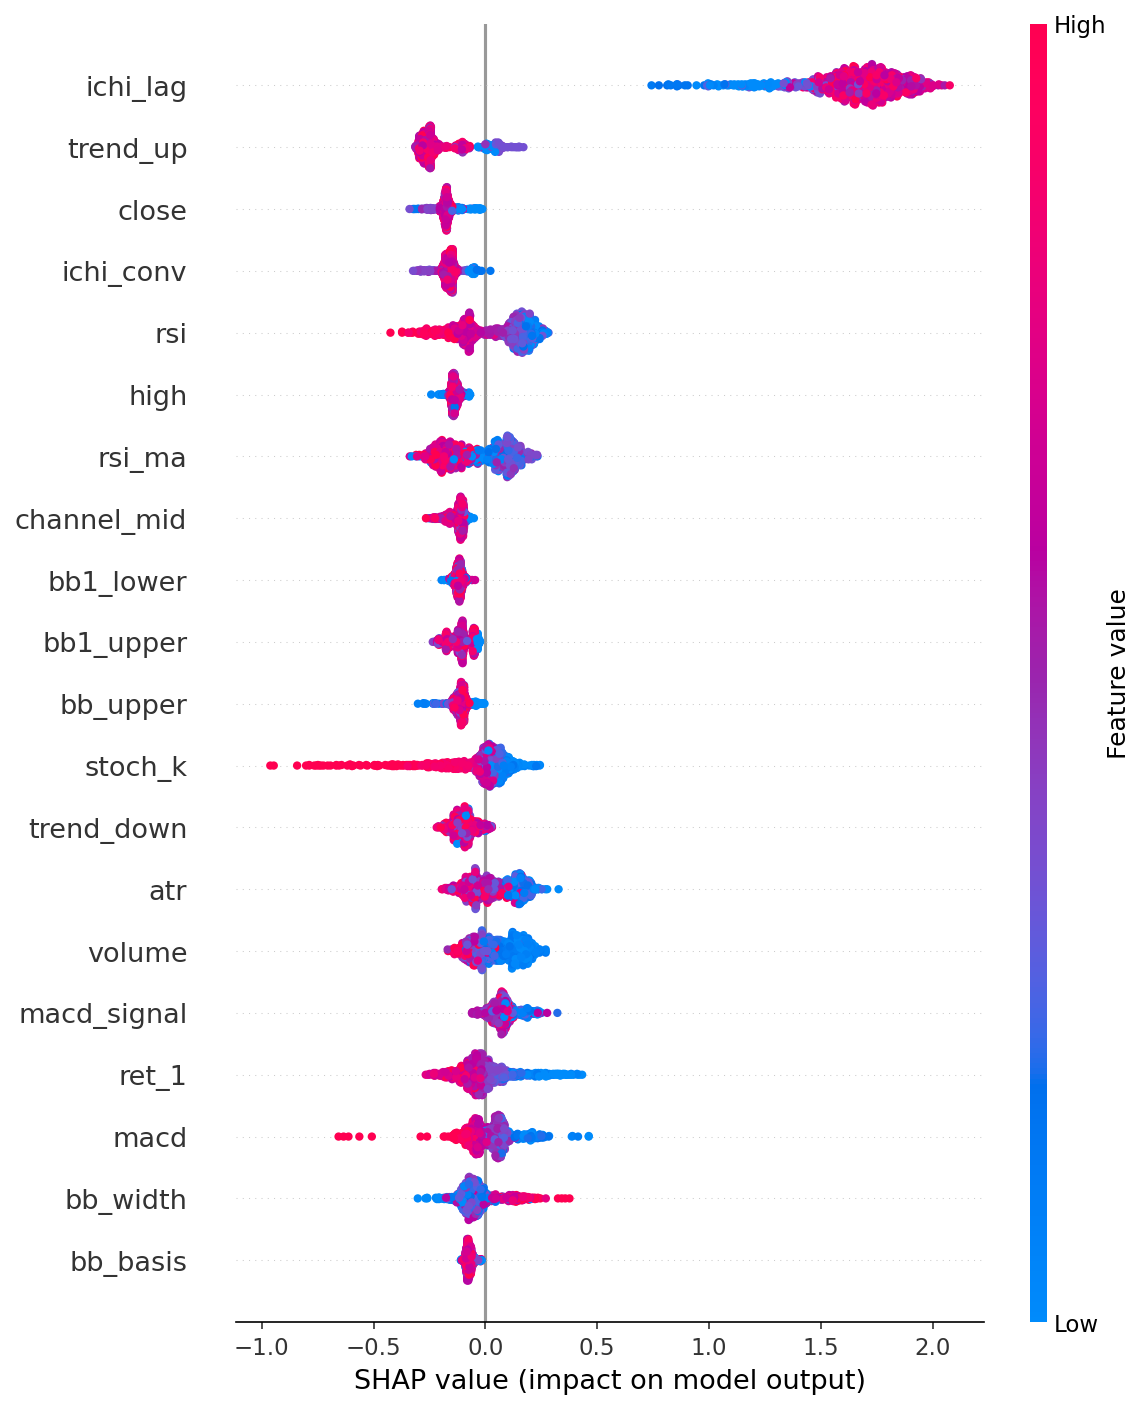

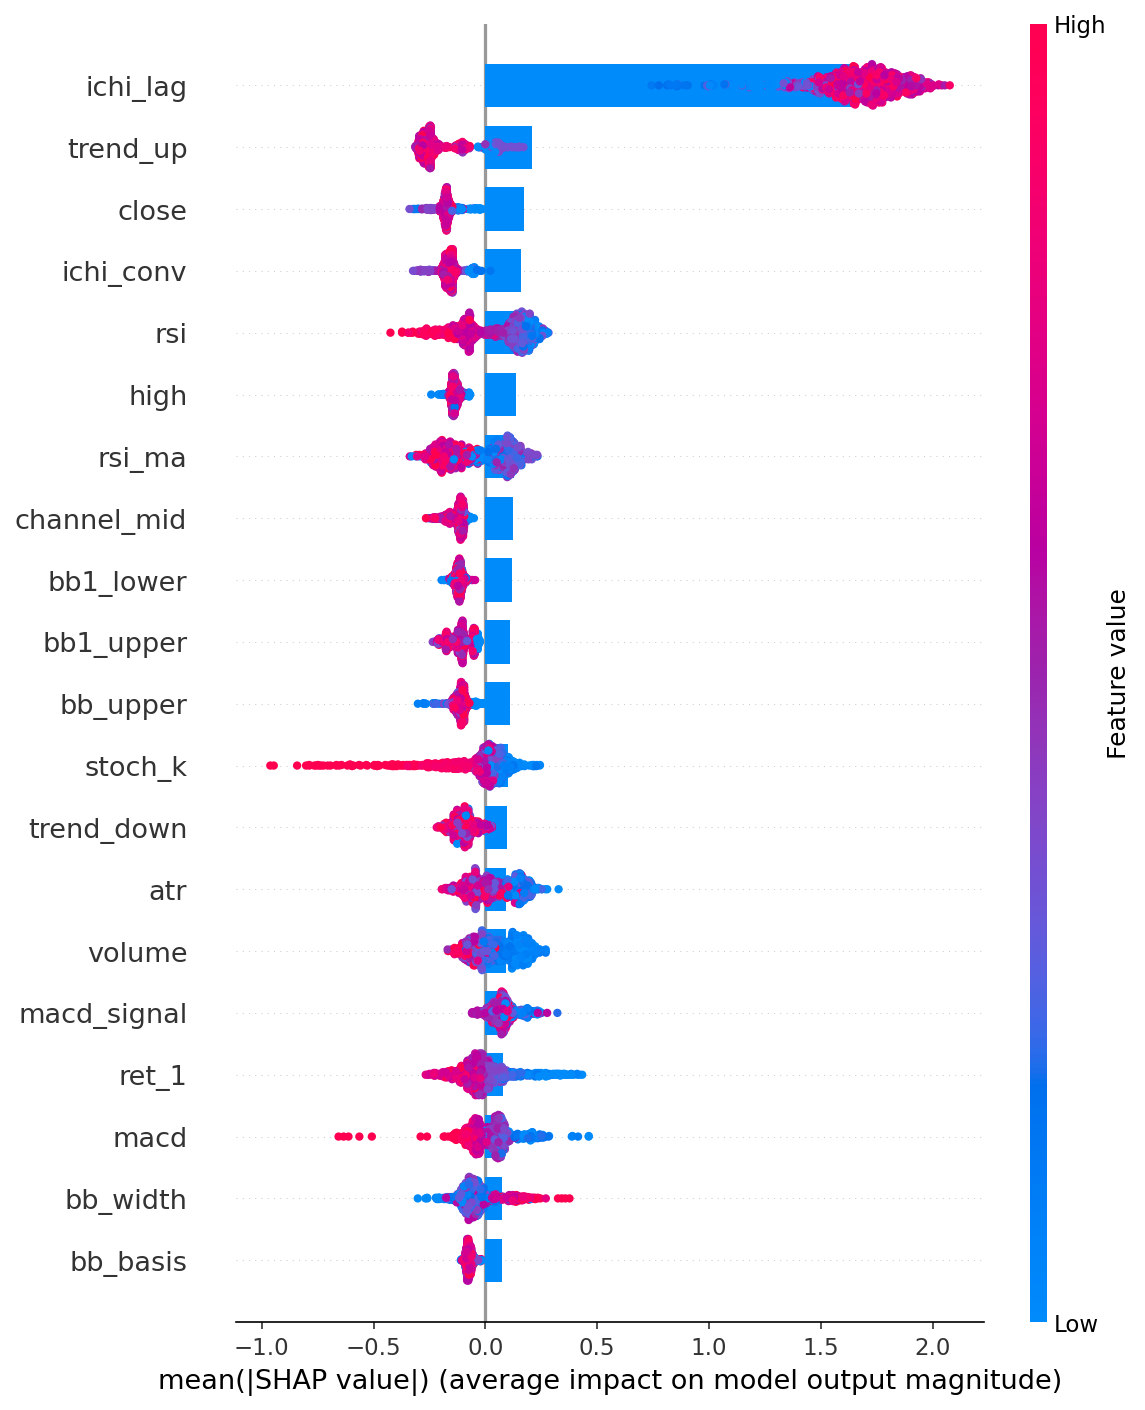

In [12]:
# Uncomment if shap is not available in your environment
# %pip install shap

import io
from pathlib import Path
import matplotlib
matplotlib.use('Agg')
import warnings
from IPython.display import Image, display

# Suppress noisy LightGBM / SHAP output format warnings
warnings.filterwarnings(
    'ignore',
    message='LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray',
    category=UserWarning,
)

IMG_DIR = Path('outputs/shap')
IMG_DIR.mkdir(parents=True, exist_ok=True)

try:
    import shap
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print("shap is not installed in this environment. Install with `pip install shap` to view explainability plots.")
else:
    shap.initjs()

    primary = results['1h']
    X_explain = primary['processed_features']['test'].sample(
        n=min(1000, len(primary['processed_features']['test'])), random_state=42
    )
    explainer = shap.TreeExplainer(primary['model'])
    shap_values = explainer.shap_values(X_explain)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_values_class1 = shap_values

    def _save_and_display(fig, filename: str):
        out_path = IMG_DIR / filename
        buf = io.BytesIO()
        fig.savefig(out_path, bbox_inches='tight', dpi=150)
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        display(Image(data=buf.read(), format='png', embed=True))

    try:
        shap.summary_plot(shap_values_class1, X_explain, feature_names=primary['feature_cols'], show=False)
        _save_and_display(plt.gcf(), 'shap_beeswarm_1h.png')

        shap.summary_plot(
            shap_values_class1,
            X_explain,
            feature_names=primary['feature_cols'],
            plot_type='bar',
            show=False,
        )
        _save_and_display(plt.gcf(), 'shap_bar_1h.png')
    except Exception as exc:
        print(f"SHAP plotting skipped: {exc}")
    finally:
        plt.close('all')


## 9. Multi-timeframe SHAP ranking
Aggregate mean(|SHAP|) per feature across 1h/4h/1d and visualize the ranking heatmap plus top-10 features.

In [ ]:
if 'shap' not in globals():
    print('SHAP not available; install shap to compute rankings.')
else:
    shap_importances = {}
    shap_samples = {}
    for tf, res in results.items():
        X_explain = res['processed_features']['test'].sample(
            n=min(800, len(res['processed_features']['test'])), random_state=42
        )
        explainer = shap.TreeExplainer(res['model'])
        shap_vals = explainer.shap_values(X_explain)
        if isinstance(shap_vals, list):
            shap_vals = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]
        shap_vals = np.array(shap_vals)
        shap_samples[tf] = shap_vals
        importance = pd.Series(np.abs(shap_vals).mean(axis=0), index=res['feature_cols'])
        shap_importances[tf] = importance.sort_values(ascending=False)

    shap_df = pd.DataFrame(shap_importances).fillna(0)
    rank_df = shap_df.rank(ascending=False, method='dense')
    rank_df['global_rank'] = rank_df.mean(axis=1)
    rank_df = rank_df.sort_values('global_rank')

    top10 = shap_df.mean(axis=1).sort_values(ascending=False).head(10)
    display(top10)

    top_features = rank_df.head(15).index
    plt.figure(figsize=(8, 6))
    sns.heatmap(rank_df.loc[top_features, ['1h', '4h', '1d']], annot=True, fmt='.0f', cmap='mako_r')
    plt.title('Feature ranking (lower is stronger)')
    heatmap_path = IMG_DIR / 'shap_rank_heatmap.png'
    plt.tight_layout()
    plt.savefig(heatmap_path, dpi=150)
    plt.close()
    print(f"Saved SHAP ranking heatmap to {heatmap_path}")


## 10. Validation grid: threshold + feature-aware filters
Search probability thresholds and feature-based filters (trend, Bollinger %B, stochastic) using Sharpe/Sortino and drawdown-aware metrics.

In [ ]:
threshold_grid = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
filter_grid = [
    {"name": "prob_only"},
    {"name": "trend_up", "trend": "up"},
    {"name": "trend_down", "trend": "down"},
    {"name": "bb_low_stoch_low", "bb_quantile": 0.2, "bb_side": "low", "stoch_quantile": 0.25, "stoch_side": "low"},
    {"name": "bb_high_trend_up", "bb_quantile": 0.8, "bb_side": "high", "trend": "up"},
]

primary = results['1h']
val_features = primary['split'].X_val.reset_index(drop=True)
val_future = primary['split'].future_val.reset_index(drop=True)
val_probs = pd.Series(primary['val_probs']).reset_index(drop=True)

strategy_rows = []
for thr in threshold_grid:
    for cfg in filter_grid:
        bt = run_backtest_with_risk(
            future_returns=val_future,
            probs=val_probs,
            features=val_features,
            threshold=thr,
            filter_cfg=cfg,
            fee=0.0004,
            slippage=0.0005,
            risk_per_trade=0.01,
            atr_mult=1.5,
        )
        row = dict(cfg)
        row['threshold'] = thr
        row.update(bt['metrics'])
        strategy_rows.append(row)

strategy_df = pd.DataFrame(strategy_rows)
strategy_df = strategy_df.sort_values(['sharpe', 'sortino'], ascending=False)
strategy_df.head(10)

best_config = strategy_df.iloc[0]
best_filter_cfg = next(cfg for cfg in filter_grid if cfg['name'] == best_config['filter'])
print('Selected config:', best_config[['filter', 'threshold', 'sharpe', 'sortino', 'max_drawdown', 'win_rate']])


## 11. Timeframe stability check
Compare AUC/PR plus top SHAP drivers to see when each timeframe is preferable or combined.

In [ ]:
if 'shap_importances' in globals():
    shap_top5 = {
        tf: imp.sort_values(ascending=False).head(5).index.tolist()
        for tf, imp in shap_importances.items()
    }
else:
    shap_top5 = {tf: [] for tf in results}

stability_rows = []
for tf, res in results.items():
    split = res['split']
    stability_rows.append({
        'timeframe': tf,
        'val_auc': roc_auc_score(split.y_val, res['val_probs']),
        'test_auc': roc_auc_score(split.y_test, res['test_probs']),
        'val_pr': average_precision_score(split.y_val, res['val_probs']),
        'test_pr': average_precision_score(split.y_test, res['test_probs']),
        'val_sharpe@best_thr': res['summary']['val_sharpe@best_thr'],
        'test_sharpe@best_thr': res['summary']['test_sharpe@best_thr'],
        'top5_shap': ', '.join(shap_top5.get(tf, [])),
    })

stability_table = pd.DataFrame(stability_rows).set_index('timeframe')
stability_table

## 12. Realistic backtest with fee/slippage + ATR sizing
Apply the best validation config on the 1h test split with ATR-based sizing, and visualize equity, exposure, and drawdown.

In [ ]:
test_features = primary['split'].X_test.reset_index(drop=True)
test_future = primary['split'].future_test.reset_index(drop=True)
test_probs = pd.Series(primary['test_probs']).reset_index(drop=True)

best_bt = run_backtest_with_risk(
    future_returns=test_future,
    probs=test_probs,
    features=test_features,
    threshold=float(best_config['threshold']),
    filter_cfg=dict(best_filter_cfg),
    fee=0.0004,
    slippage=0.0005,
    risk_per_trade=0.01,
    atr_mult=1.5,
)

best_metrics = pd.Series(best_bt['metrics'])
best_metrics

In [ ]:
backtest_dir = Path('outputs/backtest')
backtest_dir.mkdir(parents=True, exist_ok=True)

curves = {
    'equity': pd.Series(best_bt['equity_curve']),
    'drawdown': pd.Series(best_bt['drawdown_curve']),
    'exposure': pd.Series(best_bt['exposure_curve']),
}

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
curves['equity'].plot(ax=axes[0], title='Equity curve (with fees/slippage)')
curves['exposure'].plot(ax=axes[1], title='Position size (fraction of equity)')
curves['drawdown'].plot(ax=axes[2], title='Drawdown')

axes[1].set_ylabel('Sizing')
axes[2].set_ylabel('Drawdown')
axes[2].set_xlabel('Trades/time steps')

plt.tight_layout()
plot_path = backtest_dir / '1h_best_equity.png'
plt.savefig(plot_path, dpi=150)
plt.close()
print(f"Saved risk-aware backtest plot to {plot_path}")


## 13. Persist models and explainability artifacts
Save LightGBM models, preprocessing objects, and SHAP ranking tables for reproducibility.

In [ ]:
model_dir = Path('outputs/models')
model_dir.mkdir(parents=True, exist_ok=True)

for tf, res in results.items():
    joblib.dump(res['model'], model_dir / f'{tf}_lgbm.pkl')
    joblib.dump(res['preprocessing'], model_dir / f'{tf}_preprocess.pkl')

if 'shap_df' in globals():
    shap_df.to_csv(IMG_DIR / 'shap_importance_table.csv')
    rank_df.to_csv(IMG_DIR / 'shap_rank_table.csv')
    print('Saved SHAP tables under outputs/shap/')
else:
    print('SHAP tables not saved because shap_df is missing in this session.')



## 14. Next Steps & Risk Layer
- Apply strategy-specific filters (reversal/trend/volatility) using the `prob_up` outputs and indicators (RSI, bb_percent, macd_hist, EMA stacks, ATR).
- Add risk management: ATR-based SL/TP, max risk per trade, exposure caps.
- Extend to multi-asset or orderbook factors when data is available.
